In [98]:
import gzip
import pandas as pd
import json
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product, groupby, chain
from scipy.stats import ttest_ind, pearsonr
from sklearn.metrics import confusion_matrix as cm, roc_curve, roc_auc_score
import math
import warnings
import requests
import matplotlib.ticker as ticker
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef as mcc ,f1_score as f1s
import scipy
import xml.etree.ElementTree as ET
from venn import venn, pseudovenn
from matplotlib.patches import ArrowStyle

In [27]:
def names(fname):
    names = json.load(open("data/caid_names.json"))

    name = names.get(fname)
    if name is None:
        if "cons" in fname:
            name = "Naive Conservation"
        elif "pdb" in fname and 'reverse' in fname:
            name = "Naive PDB"
        elif "gene3d" in fname and 'reverse' in fname:
            name = "Naive Gene3D"
        elif "random" in fname:
            name = "Random"
        elif "dataset" in fname:
            name = "Shuffled dataset"
        elif "target" in fname:
            name = "Shuffled targets"
        elif "fix" in fname:
            name = "Fixed ID content"
        elif "ref" in fname:
            name = "Reference"
    return name
    

In [3]:
# set cwd and paths
cwd = "/home/marnec/Projects/CAID"
results_d = cwd + "/results/"
baseline_d = cwd + "/baseline/"

In [4]:
# set reference pool; nan rule
refpool = "disprot-disorder"
nanrule = "simple"
ref = refpool

In [5]:
# set ouptut type; predictor; scope; threshold optimization; result type
outtype = "analysis"
pred = "all"
scope = "dataset"
threshold = "default"

In [6]:
# set result type {metrics, pr, roc, cmat, predictions}; extension
restype = "metrics"
extension = "csv"

In [7]:
# build result file name
metrics_f = results_d + ".".join([ref, outtype, pred, scope, threshold, restype, extension])

def load_metrics(results_d, ref, scope, threshold, restype):
    idx_col = 0 if scope == "dataset" else [0, 1]
    df = pd.read_csv(results_d + ".".join([ref, "analysis", "all", scope, threshold, restype, "csv"]), index_col=idx_col)
    return df

In [8]:
def load_baseline(baseline_d, ref, basetype, scope, threshold, restype):
    if basetype in {"random", "shuffletargets", "shuffledataset"}:
        df = pd.read_csv(baseline_d + ".".join([ref, basetype, "avg", scope, threshold, restype,"csv"]), index_col=0)
        # select only mean row
        df = df.loc["mean"].to_frame(basetype).T
    else:
        df = pd.read_csv(baseline_d + ".".join([ref, basetype, "all", scope, threshold, restype,"csv"]), index_col=0)
    return df

def merge_baselines(random, shfdat, shftgt, cons, *naive):
    return pd.concat([random, shfdat, shftgt, cons, *naive])

In [9]:
# load dataset metrics
dat_pred_metrics = load_metrics(results_d, ref, scope, threshold, restype)
dat_base_metrics = merge_baselines(
    load_baseline(baseline_d, ref, "random", scope, threshold, "metrics"),                         # baseline random
    load_baseline(baseline_d, ref, "shuffledataset", scope, threshold, "metrics"),                 # baseline shuffle dataset
    load_baseline(baseline_d, ref, "shuffletargets", scope, threshold, "metrics"),                 # baseline shuffle target
    load_baseline(baseline_d, ref, "cons", scope, threshold, "metrics"),                           # baseline cons
    load_baseline(baseline_d, ref, "naive-pdb-atleast-reverse", scope, threshold, "metrics"))         # baseline naive

IMPORTANT:
* dataset: new-disprot_all_simple:
    * new: last round annotations
    * disprot: disorder comes from disprot annotations
    * all: no filtering by method (xray, nmr...)
    * simple: residues falling out of disprot annotaions are considered ordered
* threshold: default 
* baselines:
    * random: completely random
    * suffledataset: random shuffling at dataset level (disorder content maintaned at dataset level)
    * shuffletarget: random shuffling at protein level (disorder content maintaned at protein level)
    * new-disprot-all_simple_cons: naive predictor based on the opposite of conservation
    * new-disprot-pdb-r_simple: what is not on pdb is disorder

## Metrics tables

* bac: balanced accuracy,
* csi: critical score index / threat score,
* f05: f 0.5 score
* f1s: f 1 score / f score,
* f2s: f 2 score
* fnr: false negative rate / miss-rate
* fom: false omission rate
* fpr: false postive rate / fall-out
* inf: informedness / bookmaker informedness 
* mcc: matthew's correlation coefficient
* mk: markedness
* npv: negative predictive value
* ppv: precision / positive predictive value
* tnr: true negative rate / specificity / selectivity 
* tpr: true positive rate / sensitivity / recall
* aucroc: area under the ROC curve
* aucpr aurea under the Precision-Recall curve
* aps: average precision score
* thr: prediction score cutoff

### Metrics calculated at dataset level

In [10]:
dat_pred_metrics.append(dat_base_metrics).sort_values('mcc', ascending=False)


,bac,csi,f05,f1s,f2s,fnr,fom,fpr,inf,mcc,mk,npv,ppv,tnr,tpr,aucroc,aucpr,aps,thr
D029_SPOT-Disorder2,0.720,0.306,0.381,0.469,0.608,0.241,0.071,0.320,0.439,0.343,0.268,0.929,0.339,0.680,0.759,0.760,0.340,0.340,0.370
D013_fIDPln,0.679,0.287,0.417,0.446,0.480,0.494,0.101,0.147,0.359,0.327,0.298,0.899,0.399,0.853,0.506,0.793,0.422,0.421,0.353
D014_fIDPnn,0.626,0.241,0.470,0.388,0.330,0.700,0.124,0.048,0.252,0.327,0.424,0.876,0.548,0.952,0.300,0.814,0.475,0.475,0.505
D025_RawMSA,0.709,0.285,0.365,0.444,0.567,0.304,0.075,0.279,0.417,0.323,0.251,0.925,0.326,0.721,0.696,0.779,0.386,0.385,0.500
D028_SPOT-Disorder1,0.707,0.274,0.343,0.430,0.577,0.252,0.068,0.334,0.414,0.311,0.234,0.932,0.302,0.666,0.748,0.744,0.268,0.268,0.460
D026_AUCpreD,0.696,0.276,0.354,0.433,0.556,0.313,0.081,0.296,0.391,0.303,0.235,0.919,0.316,0.704,0.687,0.757,0.479,0.312,0.500
D002_Predisorder,0.695,0.264,0.324,0.418,0.588,0.193,0.063,0.417,0.390,0.292,0.219,0.937,0.282,0.583,0.807,0.747,0.325,0.324,0.500
D018_ESpritz-D,0.632,0.242,0.417,0.390,0.366,0.648,0.121,0.088,0.264,0.289,0.316,0.879,0.437,0.912,0.352,0.774,0.410,0.409,0.508
shuffletargets,0.644,0.253,0.403,0.403,0.403,0.597,0.116,0.116,0.288,0.288,0.288,0.884,0.403,0.884,0.403,0.644,0.452,0.259,1.000
D008_IsUnstruct,0.692,0.260,0.325,0.413,0.565,0.252,0.071,0.363,0.385,0.287,0.214,0.929,0.285,0.637,0.748,0.744,0.323,0.314,0.500


In [11]:
# load target metrics
tgt_pred_metrics = load_metrics(results_d, ref, "target", threshold, restype)                         # predictors metrics
bts_pred_metrics = load_metrics(results_d, ref, "bootstrap", threshold, restype)                      # predictors bootstrap
tgt_base_metrics = merge_baselines(
    load_baseline(baseline_d, ref, "random", "target", threshold, "metrics"),                         # baseline random
    load_baseline(baseline_d, ref, "shuffledataset", "target", threshold, "metrics"),                 # baseline shuffle dataset
    load_baseline(baseline_d, ref, "shuffletargets", "target", threshold, "metrics"),                 # baseline shuffle target
    load_baseline(baseline_d, ref, "cons", "target", threshold, "metrics"),                           # baseline cons
    load_baseline(baseline_d, ref, "naive-pdb-atleast-reverse", "target", threshold, "metrics"))  # baseline naive

KeyError: 'mean'

###  Metrics calculated at target level

In [ ]:
# performance averaged over targets
tgt_pred_metrics.groupby(level=0).mean().append(tgt_base_metrics.groupby(level=0).mean()).sort_values("mcc", ascending=False).round(3)

In [ ]:
def plot_dataset_target_metric(metric):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    
    
    # plot dataset metrics on left subplot
    dat_m = dat_pred_metrics[metric].sort_values(ascending=False).append(
        dat_base_metrics[metric].sort_values(ascending=False))
    
    ax = dat_m.plot.bar(
        ax=axes[0],
        color=['silver']*len(dat_pred_metrics) + ['grey']*len(dat_base_metrics),
        yerr=bts_pred_metrics.xs('bac', level=1)[["lo", 'hi']].reindex(dat_m.index)
    )
    ax.axhline(dat_base_metrics[metric].max())
    
    # plot target metrics on right subplot
    tgt_m = tgt_pred_metrics.groupby(level=0).mean()[metric].sort_values(ascending=False).append(
        tgt_base_metrics.groupby(level=0).mean()[metric].sort_values(ascending=False))
        
    ax = tgt_m.plot.bar(
        ax=axes[1], 
        color=['silver']*len(tgt_pred_metrics.groupby(level=0).mean()) + ['grey']*len(tgt_base_metrics.groupby(level=0).mean()),
        yerr=tgt_pred_metrics.groupby(level=0).std()[metric].append(
            tgt_base_metrics.groupby(level=0).std()[metric])[tgt_m.index] / 2)
    ax.axhline(tgt_base_metrics.groupby(level=0).mean()[metric].max())

## Plot of single metrics at dataset and target levels with errors
### Balanced accuracy
* dataset level (sx); error: confidence interval calculated on 1000-rounds bootstrap (invisible since too small)
* target level (dx); standard deviation

In [ ]:
plot_dataset_target_metric("bac")

### F 1 score
* dataset level (sx); error: confidence interval calculated on 1000-rounds bootstrap (invisible since too small)
* target level (dx); standard deviation

In [ ]:
plot_dataset_target_metric("f1s")

### MCC
* dataset level (sx); error: confidence interval calculated on 1000-rounds bootstrap (invisible since too small)
* target level (dx); standard deviation

In [ ]:
plot_dataset_target_metric("mcc")

## Example of confidence interval
Confidence Interval for the distribution of 1000 Balanced Accuracy (calculated at the dataset level) scores for IUpred2A.

In [ ]:
m = "bac"
lo, hi, thr = bts_pred_metrics.loc["D003_IUPred2A-long"].loc[m]
fig, ax = plt.subplots(figsize=[5, 4])
ax = pd.read_csv(
    "/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.D003_IUPred2A-long.bootstrap.metrics.csv",
    index_col=[0, 1])[str(thr)].xs(m, level=1).plot.hist(ax=ax, color='grey')
_ = ax.axvline(hi, c='r', linestyle='--')
_ = ax.axvline(lo, c='r', linestyle='--')

## MCC per target per predictor
Heatmap representing the MCC for each target for each predictor. Sorted by average-target MCC (big-->small), which can be seen on upper tick labels.

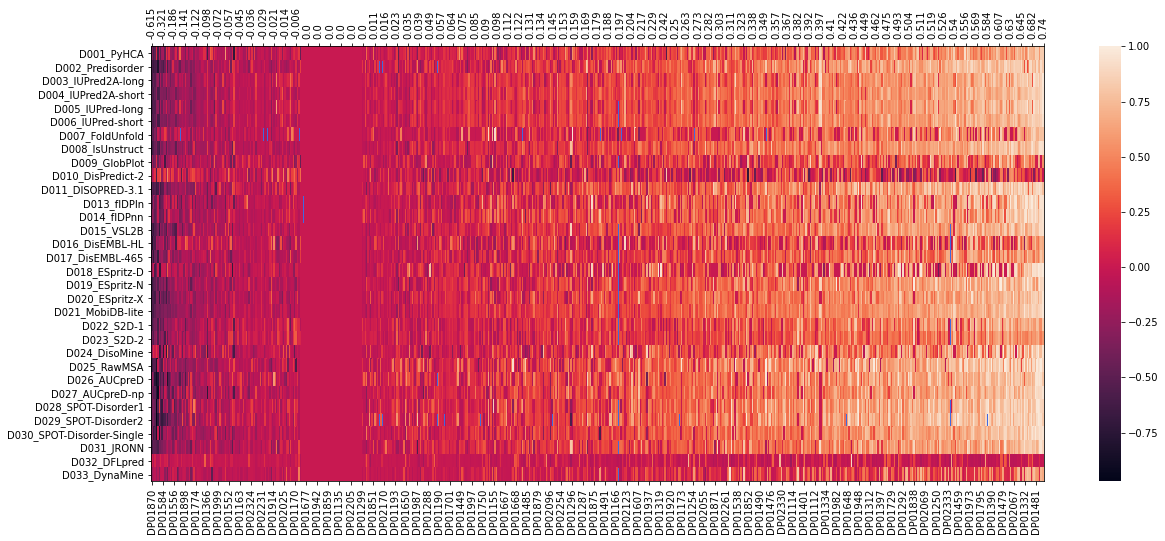

In [3]:
fig , ax = plt.subplots(figsize=(20, 8))
tgt_pred_metrics = pd.read_csv('../results/disprot-disorder.analysis.all.target.mcc.metrics.csv', index_col=[0,1])

tgt_pred_metrics_avg = tgt_pred_metrics['mcc'].unstack().mean().sort_values()


ax.set_facecolor('royalblue')
ax = sns.heatmap(tgt_pred_metrics["mcc"].unstack().reindex(tgt_pred_metrics_avg.index, axis=1), ax=ax)
ax2 = ax.twiny()
ax2.set_xticks(ax.xaxis.get_ticklocs())
ax2.set_xticklabels(tgt_pred_metrics_avg.values[[list(tgt_pred_metrics_avg.index).index(l.get_text()) for l in ax.xaxis.get_ticklabels()]].round(3))
ax2.tick_params(axis='x', rotation=90);


## Predictor correlation
MCC calculated at the target level of all predictors against all predictors. Each point is a target, their coordinates are their MCC calculated from predictor x and predictor y. The Diagonal shows the distribution of MCC for predictor x=y

In [ ]:
t = tgt_pred_metrics["mcc"].unstack().reindex(tgt_pred_metrics["mcc"].groupby(level=0).mean().sort_values(ascending=False).index)
sns.pairplot(t.head(2).T);
# plt.savefig('test.png')

### ROC curve
ROC curve. x axis 1-specificity; y axis sensitivity. Only first 10 best ranking methods are shown. Ranking is based on ROC AUC.

In [242]:
pred_rocs = pd.read_csv("../results/disprot-disorder.analysis.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
naive_roc = pd.read_csv("../baseline/disprot-disorder.naive-pdb-atleast-reverse.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
cons_roc = pd.read_csv("../baseline/disprot-disorder.naive-gene3d-reverse.all.dataset._.roc.csv", index_col=[0], header=[0,1,2])
pred_rocs.rename(names, axis=1, level=0, inplace=True)

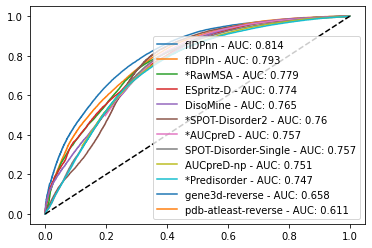

In [243]:
# create auc ranking of all predictor + baselines
auc_roc = sorted(pred_rocs.join(naive_roc).join(cons_roc).columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
# select first 10 predictors 
rocs = pred_rocs.reindex(list(zip(*auc_roc))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
rocs = rocs.append(naive_roc.T) if naive_roc.index.get_level_values(0)[0] not in rocs.index.get_level_values('predictor').unique() else rocs
rocs = rocs.append(cons_roc.T) if cons_roc.index.get_level_values(0)[0] not in rocs.index.get_level_values('predictor').unique() else rocs
# recreate auc ranking with first 10 predictors and baselines
auc_roc = sorted(rocs.index.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
lines = plt.plot(*rocs.reindex(list(zip(*auc_roc))[0], level=0).values)
plt.plot([0, 1], [0, 1], color='k', linestyle='--')
plt.legend(lines, ["{} - AUC: {}".format(*t) for t in auc_roc]);

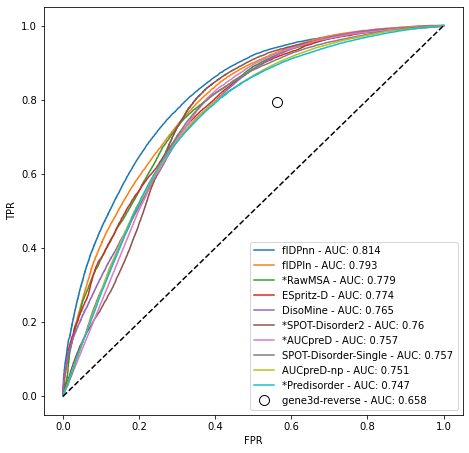

In [248]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))

auc_rocs = pred_rocs
auc_rocs = sorted(auc_rocs.columns.droplevel(2).unique(), key=lambda t: t[1], reverse=True)
rocs = pred_rocs.reindex(list(zip(*auc_rocs))[0], axis=1, level=0)

for p in rocs.columns.get_level_values(0).unique()[:10]:
    ax.plot(*pred_rocs[p].dropna().T.values, label=p)

idx = naive_roc.index.values - 0.5
ax.plot(*naive_roc.iloc[idx[idx > 0].argmin()], marker='o', label='Naive PDB', markeredgecolor='k', markerfacecolor='w', markersize=10, c='w')
plt.legend(ax.get_legend_handles_labels()[0], ["{} - AUC: {}".format(*t) for t in auc_roc])

ax.plot([0, 1], [0, 1], color='k', linestyle='--')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR");

### Precision-Recall curve
Precision-Recall curve. x axis recall; y axis precision. Only first 10 best ranking methods are shown.
* (sx) Ranking is based on PR AUC
* (dx) Ranking is based on APS (average precision score)

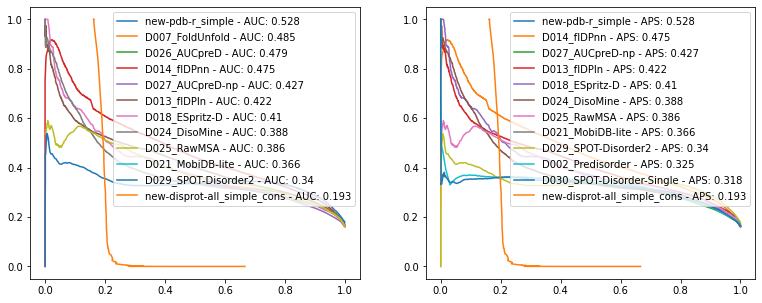

In [33]:
fig, axes = plt.subplots(1,2, figsize=(13, 5))
pred_prcs = pd.read_csv("/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.all.dataset._.pr.csv", index_col=[0], header=[0,1,2,3])
naive_prc = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.dataset._.pr.csv", index_col=[0], header=[0,1,2, 3])
cons_prc = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.cons.all.dataset._.pr.csv", index_col=[0], header=[0,1,2,3])

auc_pr = sorted(pred_prcs.join(naive_prc).join(cons_prc).columns.droplevel([2, 3]).unique(), key=lambda t: t[1], reverse=True)
aps_pr = sorted(pred_prcs.columns.droplevel([1, 3]).unique(), key=lambda t: t[1], reverse=True)

# select first 10 predictors (based on AUC)
prcs = pred_prcs.reindex(list(zip(*auc_pr))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
prcs = prcs.append(naive_prc.T) if naive_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
prcs = prcs.append(cons_prc.T) if cons_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
# recreate auc ranking with first 10 predictors and baselines
auc_pr = sorted(prcs.index.droplevel([2,3]).unique(), key=lambda t: t[1], reverse=True)
lines = axes[0].plot(*prcs.reindex(list(zip(*auc_pr))[0], level=0).values)
axes[0].legend(lines, ["{} - AUC: {}".format(*t) for t in auc_pr]);


# select first 10 predictors (based on APS)
prcs = pred_prcs.reindex(list(zip(*aps_pr))[0], axis=1, level=0).T.head(20)
# add baselines if they are not among the best 10
prcs = prcs.append(naive_prc.T) if naive_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
prcs = prcs.append(cons_prc.T) if cons_prc.index.get_level_values(0)[0] not in prcs.index.get_level_values('predictor').unique() else prcs
# recreate auc ranking with first 10 predictors and baselines
aps_pr = sorted(prcs.index.droplevel([2,3]).unique(), key=lambda t: t[1], reverse=True)
lines = axes[1].plot(*prcs.reindex(list(zip(*aps_pr))[0], level=0).values)
axes[1].legend(lines, ["{} - APS: {}".format(*t) for t in aps_pr]);

## Metrics correlation
### Pearson correlation between metrics calculated at the dataset level

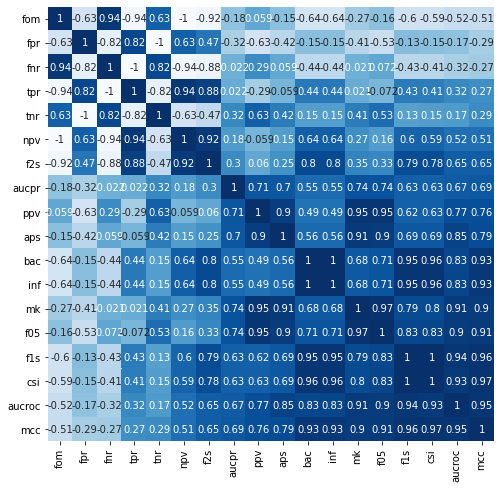

In [34]:
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(dat_pred_metrics.reindex(dat_pred_metrics.corr().mean().sort_values().drop('thr').index, axis=1).corr(), cmap='Blues', cbar=False, annot=True)

### Clustering between metrics calculated at the dataset level
Clustering distance is calculated as correlation 

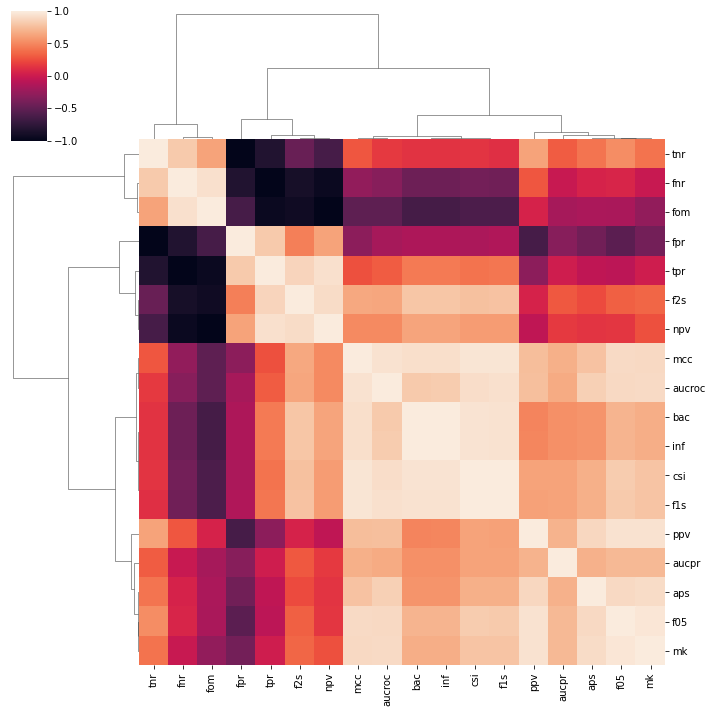

In [35]:
g = sns.clustermap(dat_pred_metrics.drop('thr', axis=1).corr(), metric="correlation")

## Ranking
### Raw ranking of each metric

In [53]:
# dat_pred_ranking = pd.read_csv('../results/disprot-disorder.analysis.all.target.metrics').append(dat_base_metrics).rank(axis=0, method='max', ascending=False, na_option='bottom').drop("thr", axis=1)
# dat_pred_ranking = dat_pred_ranking.reindex(dat_pred_ranking.mean(axis=1).sort_values().index)
# dat_pred_ranking
metrics_selection = ['bac', 'f1s', 'fpr', 'mcc', 'ppv', 'tpr', 'tnr']
dat_pred_ranking = pd.concat([
    pd.read_csv('../results/disprot-disorder.analysis.all.target.mcc.metrics.csv', index_col=[0,1]).groupby(level=0).mean(),
    pd.read_csv('../baseline/disprot-disorder.naive-pdb-atleast-reverse.all.target.mcc.metrics.csv', index_col=[0,1]).groupby(level=0).mean(),
    pd.read_csv('../baseline/disprot-disorder.naive-gene3d-reverse.all.target.mcc.metrics.csv', index_col=[0,1]).groupby(level=0).mean(),
    pd.concat([
        pd.read_csv('../baseline/disprot-disorder.random.all.target.mcc.metrics.csv', index_col=[0,1]).mean(),
        pd.read_csv('../baseline/disprot-disorder.shuffledataset.all.target.mcc.metrics.csv', index_col=[0,1]).mean(),
        pd.read_csv('../baseline/disprot-disorder.shuffletargets.all.target.mcc.metrics.csv', index_col=[0,1]).mean(),
        pd.read_csv('../baseline/disprot-disorder.fixedposfrc.all.target.mcc.metrics.csv', index_col=[0,1]).mean()], axis=1, keys=['random', 'shuffledataset', 'shuffletargets', 'fixedposfrc']).T])
dat_pred_ranking = dat_pred_ranking[metrics_selection].rank(axis=0, method='max', ascending=False, na_option='bottom')
dat_pred_ranking = dat_pred_ranking.reindex(dat_pred_ranking.mean(axis=1).sort_values().index)

,bac,csi,f05,f1s,f2s,fnr,fom,fpr,inf,mcc,mk,npv,ppv,tnr,tpr,thr
D001_PyHCA,0.641252,0.290156,0.366530,0.392540,0.460559,0.378061,0.194854,0.347768,0.263050,0.198626,0.174519,0.805146,0.369372,0.652232,0.621939,0.492
D002_Predisorder,0.671305,0.330346,0.415125,0.429209,0.479494,0.398626,0.187678,0.259923,0.329980,0.262791,0.237530,0.812322,0.425206,0.740077,0.601374,0.564
D003_IUPred2A-long,0.660966,0.312713,0.400140,0.410677,0.460863,0.403792,0.181760,0.279210,0.302432,0.248689,0.243411,0.818235,0.425174,0.720790,0.596208,0.477
D004_IUPred2A-short,0.674155,0.319413,0.403176,0.423735,0.482724,0.374985,0.180684,0.279716,0.335093,0.255933,0.225929,0.819316,0.406615,0.720284,0.625015,0.428
D005_IUPred-long,0.662765,0.316010,0.402855,0.413042,0.462415,0.403959,0.178567,0.276290,0.304163,0.251676,0.247469,0.821433,0.426036,0.723710,0.596041,0.486
D006_IUPred-short,0.675284,0.318919,0.402440,0.424278,0.485476,0.367614,0.180516,0.285238,0.337454,0.255805,0.224530,0.819484,0.405047,0.714762,0.632386,0.424
D007_FoldUnfold,0.619805,0.286454,0.371428,0.386105,0.443084,0.393320,0.407594,0.381969,0.207929,0.168969,-0.025092,0.592406,0.382502,0.618031,0.606680,1.000
D008_IsUnstruct,0.666644,0.322152,0.400754,0.425245,0.488132,0.368009,0.186440,0.304394,0.316869,0.244370,0.214220,0.813560,0.400658,0.695606,0.631991,0.600
D009_GlobPlot,0.560482,0.183921,0.301369,0.277425,0.289364,0.652561,0.228749,0.191093,0.160509,0.135619,0.136901,0.771251,0.365648,0.808907,0.347439,0.481
D010_DisPredict-2,0.558317,0.232546,0.295369,0.318475,0.382865,0.457170,0.249312,0.446795,0.073099,0.062083,0.056325,0.750688,0.305637,0.553205,0.542830,0.438


### Average Overall Ranking
Average Overall ranking of predictors based on multiple metrics. For each metric a ranking is calculated so that each predictor has a distribution of rankings. THe matrix represents the statistical significance (expressed as p-value) of the difference between distribution of rankings. The order of predictors in the matrix reflects the overall ranking (average of the distribution of ranking).

In [51]:
cartesian_product = product(dat_pred_ranking.index, dat_pred_ranking.index)
dat_pred_ranking_pvals = [[*couple, ttest_ind(*dat_pred_ranking.loc[[*couple]].values, equal_var=False)[1]] for couple in cartesian_product]
dat_pred_ranking_pvals = pd.DataFrame(dat_pred_ranking_pvals).set_index([0, 1]).unstack()
dat_pred_ranking_pvals.columns = dat_pred_ranking_pvals.columns.droplevel(0)
dat_pred_ranking_pvals = dat_pred_ranking_pvals.reindex(index=dat_pred_ranking.index, columns=dat_pred_ranking.index).round(2)

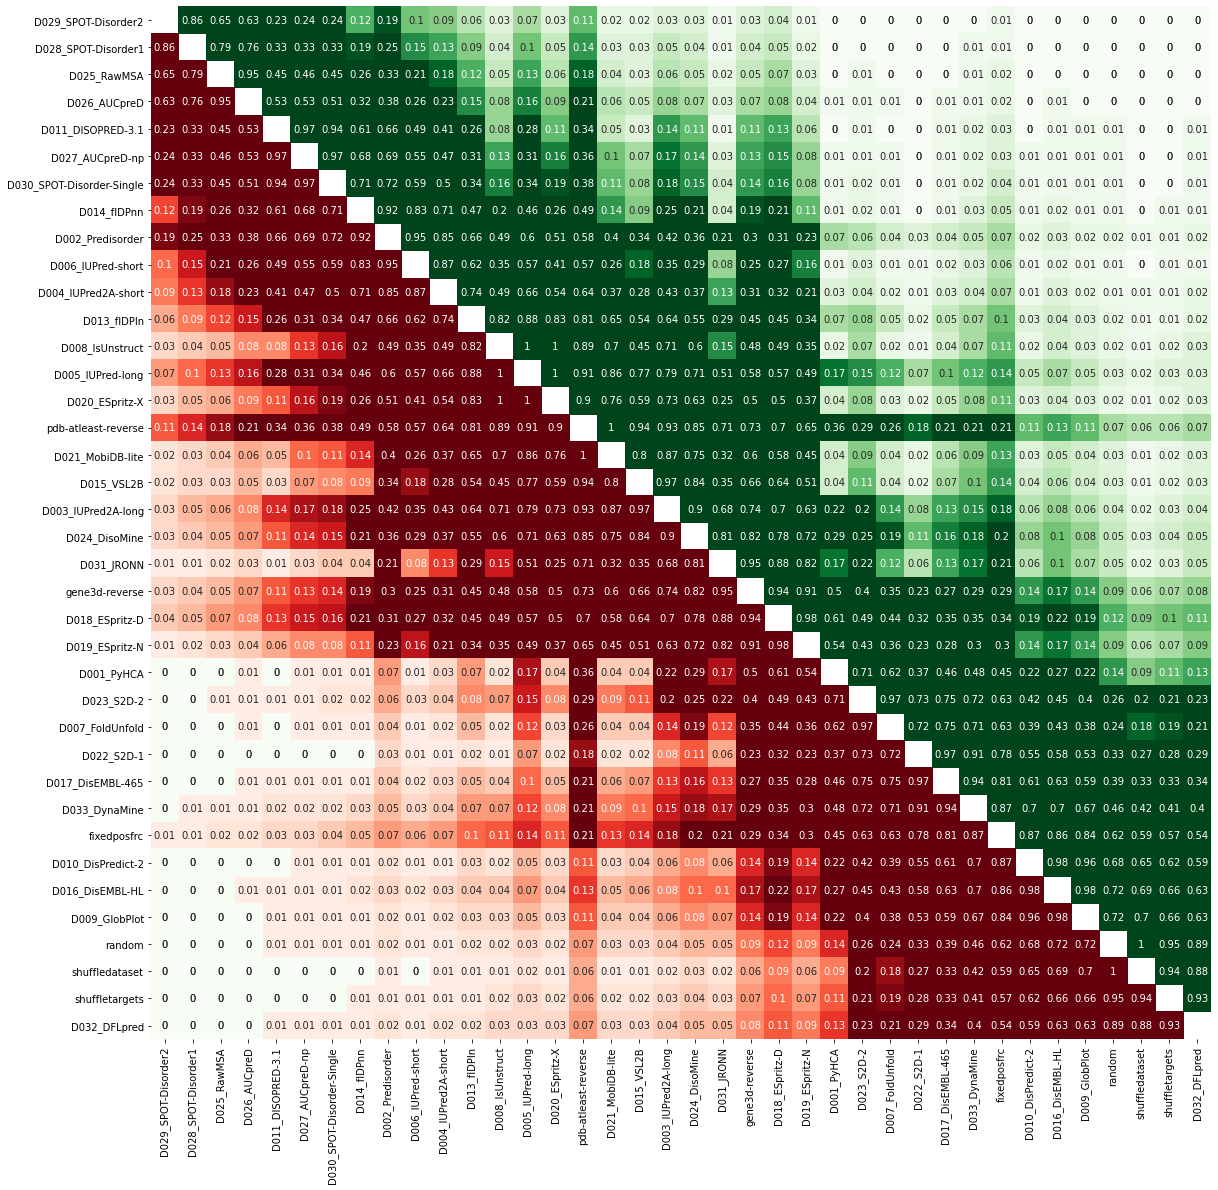

In [52]:
giog, axes = plt.subplots(figsize=(len(dat_pred_ranking_pvals)/2,len(dat_pred_ranking_pvals)/2))
ax = sns.heatmap(dat_pred_ranking_pvals,annot=True, mask=np.triu(dat_pred_ranking_pvals), cmap="Reds", cbar=False, center=0.1, vmax=0.2)
ax = sns.heatmap(dat_pred_ranking_pvals,annot=True, mask=np.tril(dat_pred_ranking_pvals), cmap="Greens", cbar=False, center=0.1, vmax=0.2)

In [39]:
pd.read_csv("../data/disprot7consensus.tsv", sep="\t", index_col=["disprot_id"])["consensus"].apply(lambda r: r.count("D")/len(r)).mean()

0.3541292880258076

In [40]:
predictions = pd.read_csv("/home/marnec/Projects/CAID/caid/results/new-disprot-all_simple.analysis.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_cons = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.cons.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_pdbr = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-pdb-r_simple.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
baseline_gene3dr = pd.read_csv("/home/marnec/Projects/CAID/caid/baseline/new-disprot-all_simple.naive-new-gene3d-r_simple.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])
predictions = pd.DataFrame({**predictions.to_dict(), **baseline_cons.to_dict(), **baseline_pdbr.to_dict(), **baseline_gene3dr.to_dict()}).dropna()

In [41]:
idcontent_ref = predictions[("ref", "states")].groupby(level=0).mean()
idcontent_pred = predictions.groupby(level=0).mean()

## Disorder content
Correlation beween disorder content in the reference and predicted disorder content. Each dot is a protein in the dataset. The legend show Pearson R value.

In [50]:
len(predictions.columns.get_level_values(0).unique())

36

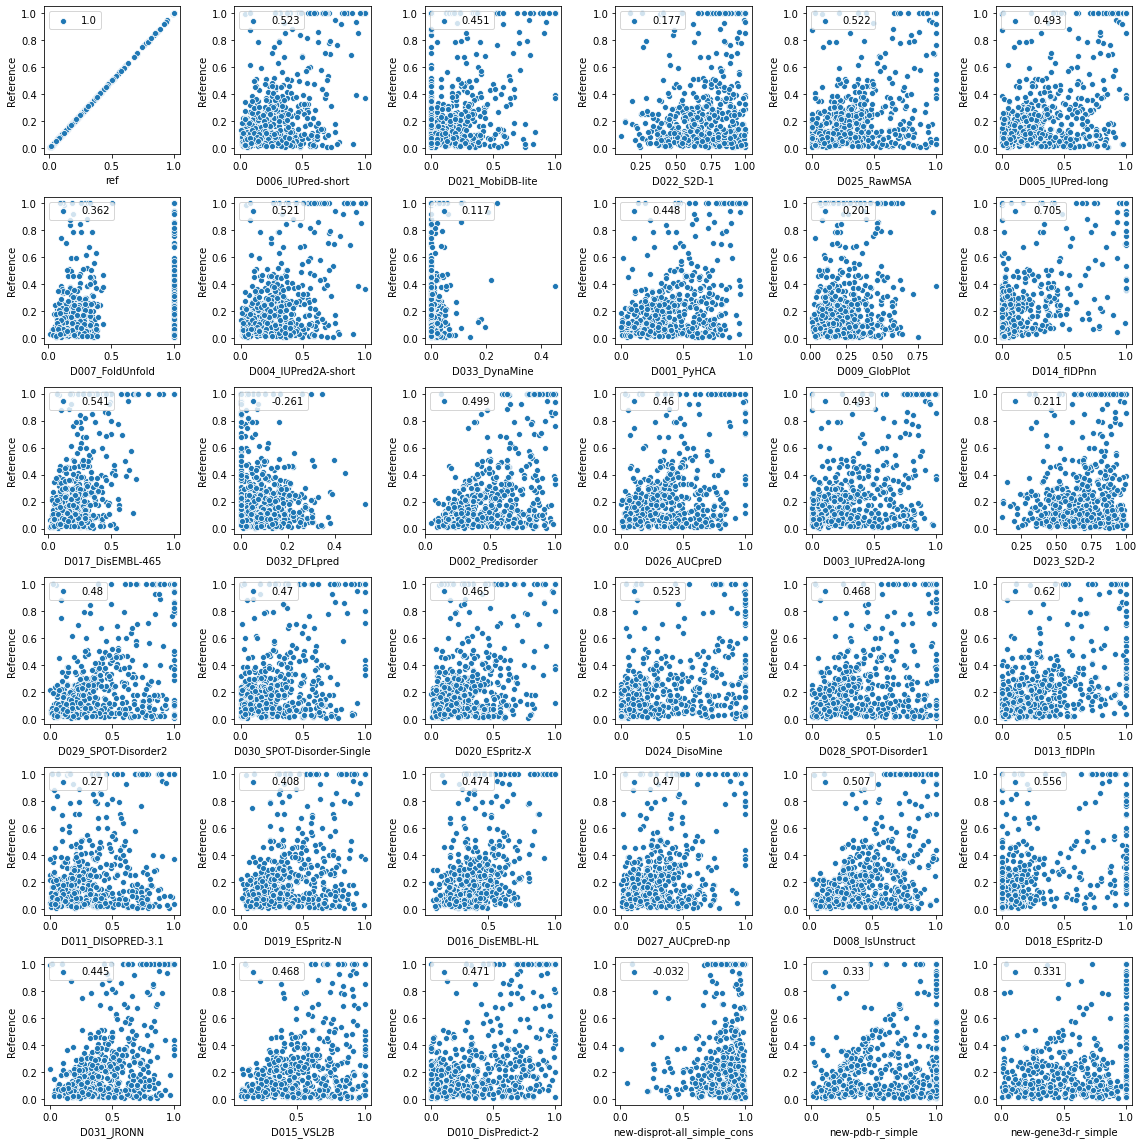

In [29]:
fig, axes = plt.subplots(6, 6, figsize=(16, 16))
axes = axes.flatten()
for ax, p in zip(axes, predictions.columns.get_level_values(0).unique()):
    x = predictions[(p, "states")].groupby(level=0).mean()
    y = idcontent_ref
    sns.scatterplot(x, y, ax=ax, label=round(pearsonr(x, y)[0], 3))
    ax.legend(loc="upper left")
    ax.set_ylabel("Reference")
    ax.set_xlabel(p)

plt.tight_layout()

## Fully disordered 
Performance of predictors on discriminate fully disordered proteins (>95% id content) from non-fully disordered proteins

In [30]:
fullid = (idcontent_pred.xs("states", axis=1, level=1).round(3) > 0.95).astype(int)
fullid_r = fullid["ref"].astype(int)
fullid_p = fullid.astype(int).drop("ref", axis=1)
fullid_cm = fullid.apply(lambda s: cm(fullid_r.values, s.values, labels=[0, 1]).ravel())
fullid_cm.index = ["tn", "fp", "fn", "tp"]
fullid_cm.T.sort_values("fp")

,tn,fp,fn,tp
ref,529,0,0,40
D016_DisEMBL-HL,529,0,36,4
D032_DFLpred,529,0,40,0
D009_GlobPlot,529,0,40,0
D033_DynaMine,529,0,40,0
D017_DisEMBL-465,529,0,38,2
D006_IUPred-short,528,1,30,10
D004_IUPred2A-short,527,2,30,10
D021_MobiDB-lite,527,2,29,11
D019_ESpritz-N,525,4,28,12


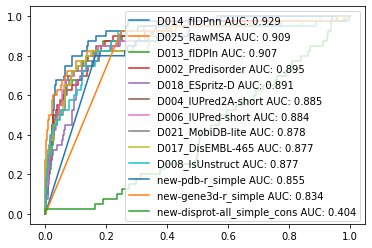

In [138]:
fullidrocs = predictions.xs("scores", level=1, axis=1).groupby(level=0).mean().apply(lambda s: roc_curve(fullid_r, s)[:-1])

fullidaucs = predictions.xs("scores", level=1, axis=1).groupby(level=0).mean().apply(lambda s: roc_auc_score(fullid_r, s))
fullidrocs = fullidrocs.to_frame().assign(auc=fullidaucs).sort_values("auc", ascending=False)

fullidrocs_p = fullidrocs.loc[["new-pdb-r_simple", "new-gene3d-r_simple", "new-disprot-all_simple_cons"]]
fullidrocs = fullidrocs.drop(["new-pdb-r_simple", "new-gene3d-r_simple", "new-disprot-all_simple_cons"])

concatperplot = fullidrocs.head(10).append(fullidrocs_p)[0]
lines = plt.plot(*[item for sublist in concatperplot for item in sublist])
_ = plt.legend(lines, ["{} AUC: {}".format(p, fullidaucs[p].round(3)) for p in concatperplot.index])


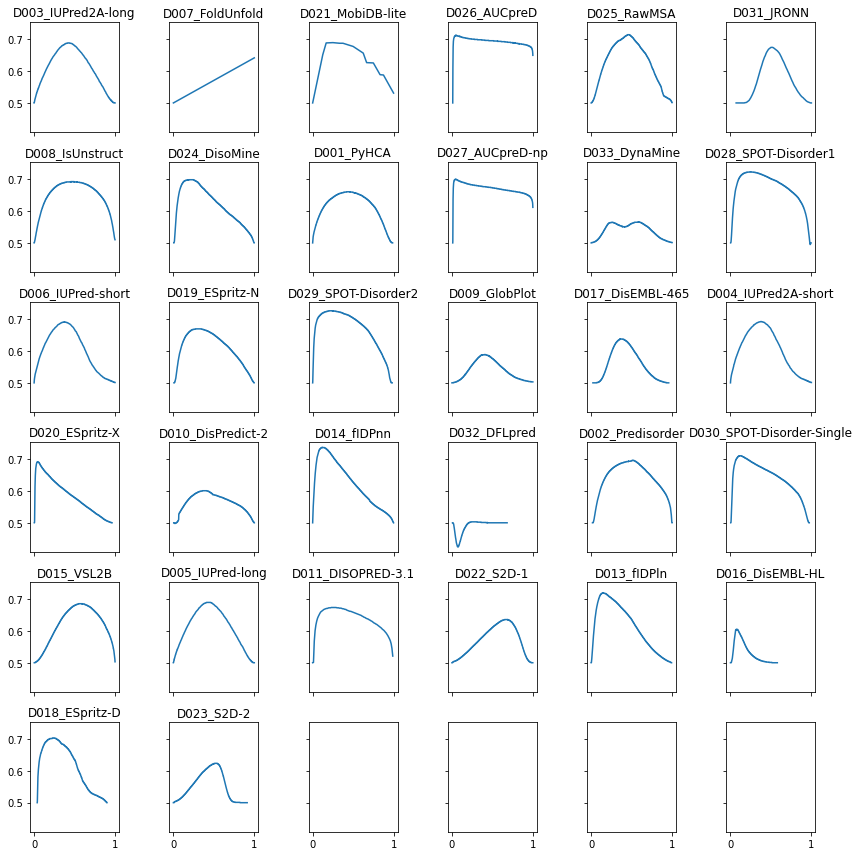

In [26]:

warnings.filterwarnings("ignore")

refbase="../data/disorder/new-disprot-all_simple.txt"
p = list(Path("../results").glob(Path(refbase).stem+".analysis.D*dataset*"))
sidesize = math.ceil(len(p)**0.5)
fig, axes = plt.subplots(sidesize, sidesize, figsize=(sidesize*2, sidesize*2),sharey=True, sharex=True)
for pdf, ax in zip(p, axes.ravel()):
    df = pd.read_csv(pdf, index_col=[0,1])
    df.columns = df.columns.values.astype(np.float)
    df = df.sort_index(axis=1)

    method = df.index.droplevel(1).unique()[0]
    df = df.reset_index(level=0, drop=True)
    df.loc['bac'].plot(ax=ax)
    ax.set_title(method)

fig.tight_layout()


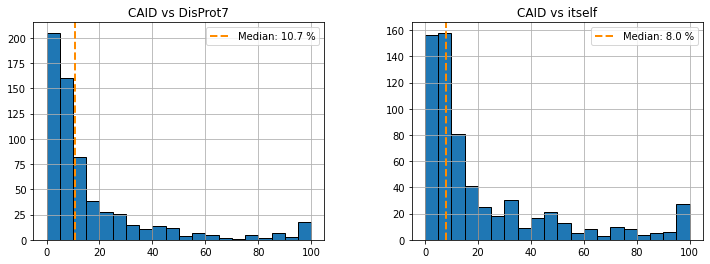

In [11]:
cons_nvn = pd.read_csv("/home/marnec/Projects/CAID/caid/data/blast_distribution_new_vs_new.txt", index_col=0)
cons_nvo = pd.read_csv("/home/marnec/Projects/CAID/caid/data/blast_distribution_new_vs_old.txt", index_col=0)
axes = pd.concat([cons_nvn, cons_nvo], axis=1).hist(edgecolor='k', figsize=(12, 4), bins=20)
axes = axes.ravel()
line = axes[0].axvline(float(cons_nvn.median()), linestyle="--", color='darkorange', linewidth=2)
l = axes[0].legend([line], ["Median: {:.1f} %".format(float(cons_nvn.median()))])
line = axes[1].axvline(float(cons_nvo.median()), linestyle="--", color='darkorange', linewidth=2)
l = axes[1].legend([line], ["Median: {:.1f} %".format(float(cons_nvo.median()))])

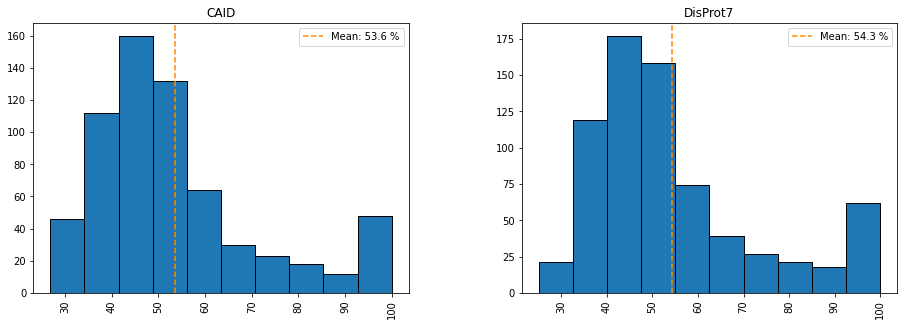

In [36]:
cons_tot = pd.read_csv("/home/marnec/Projects/caid/data/blast_distribution.txt", index_col=0)
axes = cons_tot.hist(by="Age", edgecolor="k", figsize=(15,5))
med_new = float(cons_tot[cons_tot["Age"] == "CAID"].mean())
med_old = float(cons_tot[cons_tot["Age"] == "DisProt7"].mean())               
line = axes[0].axvline(med_new, color="darkorange", linestyle="--")
axes[0].legend([line], ["Mean: {:.1f} %".format(med_new)])
line = axes[1].axvline(med_old, color="darkorange", linestyle="--")
l = axes[1].legend([line], ["Mean: {:.1f} %".format(med_old)])

Text(0.5, 1.0, 'Number of regions (PDB)')

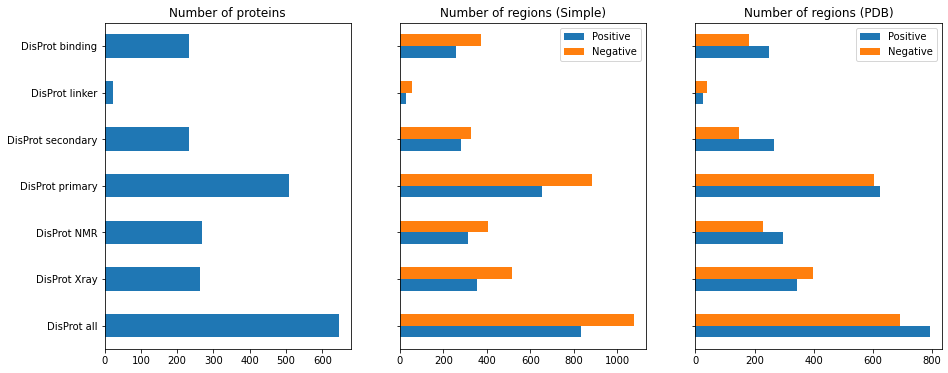

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6), sharey=True)
counts = pd.read_csv("../data/reference.csv", index_col=[0,1], header=[0,1,2])
counts.loc["CAID"].drop("PDB missing").Simple.Regions.plot.barh(ax=axes[1])
rects = counts.loc["CAID"].drop("PDB missing").PDB.Regions.plot.barh(ax=axes[2])

counts.loc["CAID"].drop("PDB missing").xs("Proteins", level=2, axis=1).plot.barh(ax=axes[0], legend=False)
axes[0].set_title("Number of proteins")
axes[1].set_title("Number of regions (Simple)")
axes[2].set_title("Number of regions (PDB)")

# counts.xs("Regions", level=1, axis=1)

Text(0.5, 1.0, 'DisProt 7 - Number of Residues')

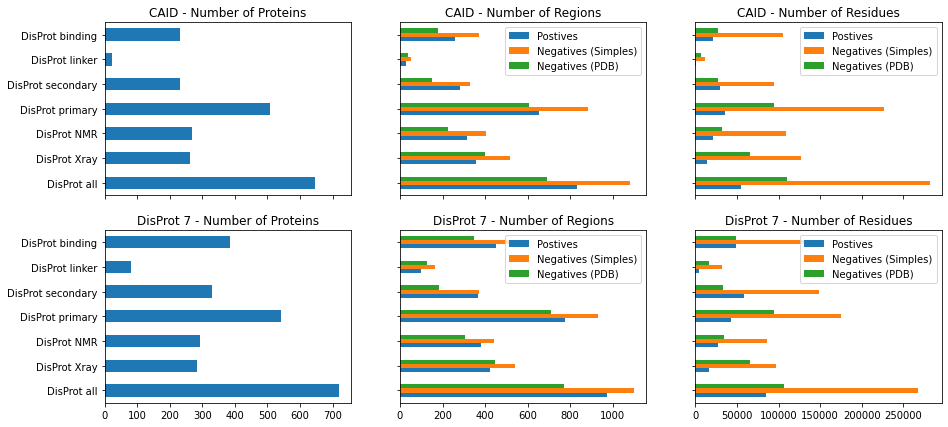

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(15, 7), sharey=True, sharex="col")
axes = axes.ravel()
counts.loc["CAID"].drop("PDB missing").xs("Proteins", level=2, axis=1).plot.barh(ax=axes[0], legend=False)
axes[0].set_title("CAID - Number of Proteins")
counts.xs("Regions", level=1, axis=1).loc["CAID"].drop("PDB missing").drop(("PDB", "Positive"), axis=1).plot.barh(ax=axes[1])
axes[1].legend(axes[1].get_legend().get_patches(), ["Postives", "Negatives (Simples)", "Negatives (PDB)"])
axes[1].set_title("CAID - Number of Regions")

counts.xs("Residues", level=1, axis=1).loc["CAID"].drop("PDB missing").drop(("PDB", "Positive"), axis=1).plot.barh(ax=axes[2])
axes[2].legend(axes[2].get_legend().get_patches(), ["Postives", "Negatives (Simples)", "Negatives (PDB)"])
axes[2].set_title("CAID - Number of Residues")

counts.loc["DisProt 7"].drop("PDB missing").xs("Proteins", level=2, axis=1).plot.barh(ax=axes[3], legend=False)
axes[3].set_title("DisProt 7 - Number of Proteins")
counts.xs("Regions", level=1, axis=1).loc["DisProt 7"].drop("PDB missing").drop(("PDB", "Positive"), axis=1).plot.barh(ax=axes[4])
axes[4].legend(axes[4].get_legend().get_patches(), ["Postives", "Negatives (Simples)", "Negatives (PDB)"])
axes[4].set_title("DisProt 7 - Number of Regions")

counts.xs("Residues", level=1, axis=1).loc["DisProt 7"].drop("PDB missing").drop(("PDB", "Positive"), axis=1).plot.barh(ax=axes[5])
axes[5].legend(axes[5].get_legend().get_patches(), ["Postives", "Negatives (Simples)", "Negatives (PDB)"])
axes[5].set_title("DisProt 7 - Number of Residues")

In [22]:
def reglen(ref_file):
    ref_file = Path(ref_file)
    pattern = {'0': 0.0, '1': 1.0, '-': np.nan}

    lens = []

    with open(ref_file) as f:
        faiter = (x[1] for x in groupby(f, lambda line: line[0] == ">"))
        for header in faiter:
            header = next(header)
            if header[0] != '#':
                acc, *desc = header[1:].strip().split()
                seq, states = map(str.strip, next(faiter))
                states = np.array([pattern.get(s, np.nan) for s in states], dtype=np.float64)
                lens.extend([sum(group) for key, group in groupby(states) if key == 1])

    return lens
 

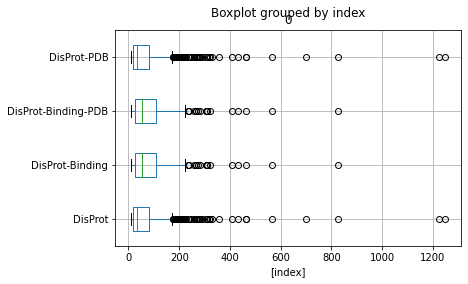

In [30]:


d = reglen("/home/marnec/Projects/caid/data/references/disorder/new-disprot-all_simple.txt")
dp = reglen("/home/marnec/Projects/caid/data/references/disorder/new-disprot-all_pdb.txt")
db = reglen("/home/marnec/Projects/caid/data/references/binding/new-disprot-binding_simple.txt")
dbp = reglen("/home/marnec/Projects/caid/data/references/binding/new-disprot-binding_pdb.txt")

pd.DataFrame(chain.from_iterable([d, dp, db, dbp]), chain.from_iterable([["DisProt"] * len(d),
                                                                         ["DisProt-PDB"] * len(dp),
                                                                         ["DisProt-Binding"] * len(db),
                                                                         ["DisProt-Binding-PDB"] * len(dbp)
                                                                        ])).reset_index().boxplot(by="index", vert=False)

In [2]:
def parse_fasta(fasta):
    faiter = (x[1] for x in groupby(fasta, lambda line: line.startswith(">")))
    for header in faiter:
        yield next(header)[1:].strip(), "".join(s.strip() for s in next(faiter))

In [5]:
disprot7_disorder = requests.get("https://www.disprot.org/api/search?release=2016_10&show_ambiguous=false&show_obsolete=false&format=fasta&namespace=structural_state&get_consensus=true").text
disprotcaid_disorder = requests.get("https://disprot.org/api/search?release=2018_11&show_ambiguous=false&show_obsolete=false&format=fasta&namespace=structural_state&get_consensus=true").text
disprot_interaction = requests.get("https://disprot.org/api/search?release=2018_11&show_ambiguous=false&show_obsolete=false&format=fasta&namespace=interaction_partner&get_consensus=true").text

disprot7_disorder = {h.split("|")[1]: s for h, s in parse_fasta(disprot7_disorder.split("\n"))}
disprotcaid_disorder = {h.split("|")[1]: s for h, s in parse_fasta(disprotcaid_disorder.split("\n")) if h.split("|")[1] not in disprot7_disorder}
disprotcaid_interaction = {h.split("|")[1]: s for h, s in parse_fasta(disprot_interaction.split("\n")) if h.split("|")[1] not in disprot7_disorder}

In [6]:
len(disprot7_disorder)

756

In [7]:
len(disprotcaid_disorder)

664

In [14]:
{h[1:].strip() for h in (line for line in open('../data/disprot-disorder.txt') if '>' in line )} - {h[1:].strip() for h in (line for line in open('../data/predictions/disorder/D003_IUPred2A-long.out') if '>' in line )}

{'DP00084', 'DP00182', 'DP00206', 'DP00334', 'DP00359', 'DP00518', 'DP01188'}

In [13]:
sum([set(s) & {'0', '1'} == {'0', '1'} for s in (l.strip() for l in open('../data/references/binding/disprot-binding-disorder') if '>' not in l)][1::2])

39

/home/marnec/Projects/CAID/caid/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/marnec/Projects/CAID/caid/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


Text(0.5, 0, 'Seconds')

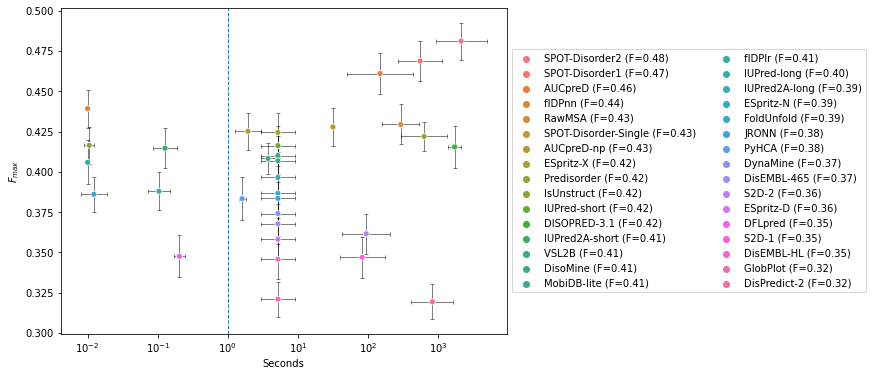

In [41]:
fig, ax = plt.subplots(figsize=(8, 6))

cputime = pd.read_csv('../data/dataset_stats/cpu_time.csv', header=[0, 1], index_col=[0]).groupby(level=0, axis=1).sum()
tgt_pred_metrics = pd.read_csv('../results/disprot-disorder.analysis.all.target.f1s.metrics.csv', index_col=[0, 1])['f1s']
# tgt_pred_metrics = pd.read_csv('../results/disprot-binding-all.analysis.all.target.f1s.metrics.csv', index_col=[0, 1])['f1s']

y = tgt_pred_metrics.groupby(level=0).mean().sort_values(ascending=False)
x = np.log10(cputime).mean().reindex(y.index).replace([np.inf, -np.inf], -2)

ax = sns.scatterplot(x=x, y=y, hue=y.index, zorder=50)

ax.errorbar(x=x,
            y=y,
            yerr=tgt_pred_metrics.groupby(level=0).std() / (len(tgt_pred_metrics) / len(y.index)) ** 0.5,
            xerr=np.log10(cputime).std().reindex(y.index),
            linewidth=0, elinewidth=0.5, c='k', capsize=2, capthick=0.5)

ax.axvline(0, linestyle='--', linewidth=1, label='1 Second')
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$10^{{{}}}$'.format(int(x))))

_ = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

pointstoname = dict(zip(*ax.get_legend_handles_labels()[::-1]))
sorter = y.sort_values(ascending=False)

ax.legend([pointstoname[k] for k in sorter.index], ["{} (F={:.2f})".format(names(k),v) for k, v in sorter.iteritems()],
          bbox_to_anchor=(1, .5), 
          loc='center left', 
          ncol=2)

ax.set_ylabel('$F_{max}$')
ax.set_xlabel('Seconds')
# fig.tight_layout()

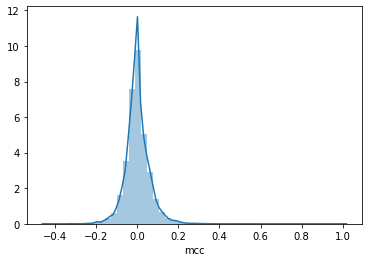

In [9]:
df = pd.read_csv('../baseline/disprot-disorder.shuffletargets.all.target.mcc.metrics.csv', index_col=[0,1]).mcc
sns.distplot(df)

In [19]:
predictions = pd.read_csv("../results/disprot-disorder.analysis.all.dataset._.predictions.csv", index_col=[0,1], header=[0,1])

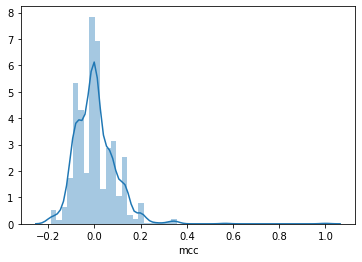

In [58]:
idc = predictions.ref.states.groupby(level=0).mean()

sns.distplot(df.loc[(df.index.get_level_values(0).unique(), idc[(idc.values<1) & (idc.values>0.8)].index)])

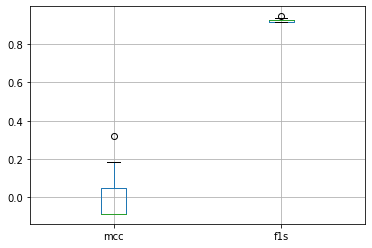

In [97]:

yt = np.greater_equal(np.random.rand(100), 0.1).astype(int)
yp = lambda t: np.random.choice(t, replace=False, size=len(t))
pd.DataFrame(np.array([[mcc(yt, yp(yt)) for _ in range(100)], [f1s(yt, yp(yt)) for _ in range(100)]]).T, columns=['mcc', 'f1s']).boxplot()

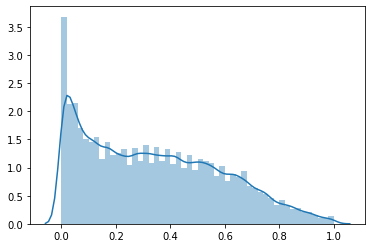

In [70]:
sns.distplot(np.loadtxt('../../vectorized_cls_metrics/tscores.txt'))

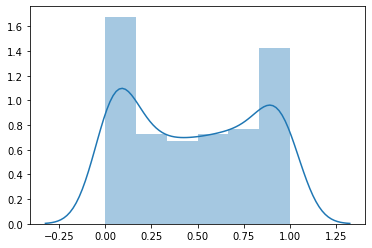

In [71]:
sns.distplot(np.loadtxt('../../vectorized_cls_metrics/tthr.txt'))

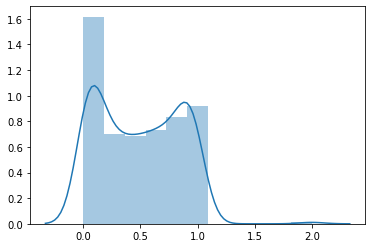

In [72]:
sns.distplot(np.loadtxt('../../vectorized_cls_metrics/rthr.txt'))

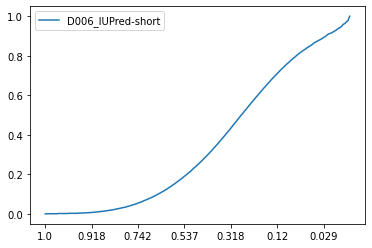

In [93]:
pd.read_csv('../results/disprot-disorder.analysis.D006_IUPred-short.dataset.metrics.csv', index_col=[0,1]).xs('fpr', level=1).T.plot()

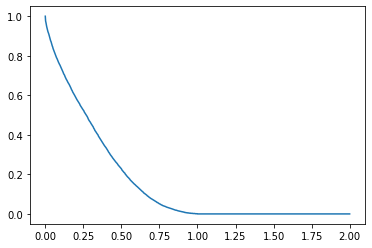

In [162]:
r = pd.read_csv('../results/disprot-disorder.analysis.all.dataset._.roc.csv', index_col=0, header=[0,1,2])['D006_IUPred-short']
a = r.xs('fpr', level=1, axis=1)['0.739']
a.name = None
a[~np.isnan(a)].plot()

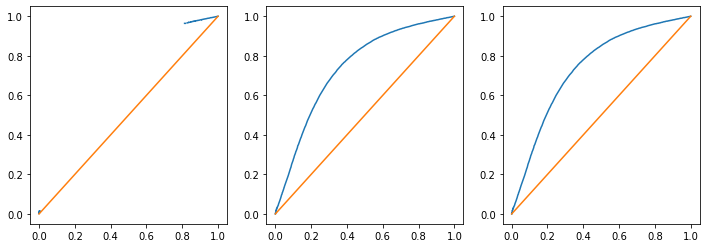

In [185]:
r = pd.read_csv('../results/disprot-disorder.analysis.all.dataset._.roc.csv', index_col=0, header=[0,1,2])['D006_IUPred-short']
# r.columns = r.columns.droplevel(0)
fig, axes = plt.subplots(1,3, figsize=(12, 4))
axes[0].plot(*r.values.T)
axes[1].plot(*r.dropna().values.T)
axes[2].plot(*r.fillna(method='ffill').values.T)
for ax in axes:
    ax.plot([0,1], [0,1])

In [75]:
pd.concat([
    pd.concat([
        pd.read_csv('../baseline/disprot-disorder-pdb-atleast.naive-pdb-atleast-reverse.all.dataset.default.cmat.csv', index_col=[0]),
        pd.read_csv('../baseline/disprot-disorder-pdb-atleast.naive-gene3d-reverse.all.dataset.default.cmat.csv', index_col=[0]),
        pd.read_csv('../baseline/disprot-disorder.naive-pdb-atleast-reverse.all.dataset.default.cmat.csv', index_col=[0]),
        pd.read_csv('../baseline/disprot-disorder.naive-gene3d-reverse.all.dataset.default.cmat.csv', index_col=[0]),
              ]),
    pd.concat([
        pd.read_csv('../baseline/disprot-disorder-pdb-atleast.naive-pdb-atleast-reverse.all.dataset.default.metrics.csv', index_col=[0])[['fpr', 'fnr']],
        pd.read_csv('../baseline/disprot-disorder-pdb-atleast.naive-gene3d-reverse.all.dataset.default.metrics.csv', index_col=[0])[['fpr', 'fnr']],
        pd.read_csv('../baseline/disprot-disorder.naive-pdb-atleast-reverse.all.dataset.default.metrics.csv', index_col=[0])[['fpr', 'fnr']],
        pd.read_csv('../baseline/disprot-disorder.naive-gene3d-reverse.all.dataset.default.metrics.csv', index_col=[0])[['fpr', 'fnr']],
              ])
    ], axis=1
)

,fn,fp,tn,tp,fpr,fnr
pdb-atleast-reverse,11188,0,123246,43690,0.000,0.204
gene3d-reverse,11469,27151,96095,43409,0.220,0.209
pdb-atleast-reverse,11188,159944,123246,43690,0.565,0.204
gene3d-reverse,11469,137569,145621,43409,0.486,0.209


In [41]:
r = '---000000000---------000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111----------'
p = '1110000000001111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111'
#   '1110000000001111111110000000000000000000000000000000000000000000000000000000000000000000000000000000000000011111111111111111111111111111111111111111111111111111'

In [42]:
p=np.array(list(p))
r=np.array(list(r))

In [43]:
p = p[r!='-'].astype(int)
r = r[r!='-'].astype(int)

In [52]:
''.join(r.astype(str))

'000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111111111111111111'

In [51]:
''.join(p.astype(str))

'000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001111111111111111111111111111111111111111111'

In [48]:

metrics.confusion_matrix(r, p).ravel()
# (tn, fp, fn, tp)

array([80,  0, 15, 43])

In [77]:
def build_table_suppl_tgt(dataset, outfolder):
    metrics_selection_tgt = ['bac', 'f1s', 'fpr', 'mcc', 'ppv', 'tpr', 'tnr']
    df = pd.concat([
        pd.read_csv('../results/{}.analysis.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=0).mean(),
        pd.read_csv('../baseline/{}.naive-pdb-atleast-reverse.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=0).mean(),
        pd.read_csv('../baseline/{}.naive-gene3d-reverse.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=0).mean(),
        pd.read_csv('../baseline/{}.random.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).mean().to_frame(name='random').T,
        pd.read_csv('../baseline/{}.shuffledataset.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).mean().to_frame(name='shuffledataset').T,
        pd.read_csv('../baseline/{}.shuffletargets.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).mean().to_frame(name='shuffletargets').T
              ]).rename(names)[metrics_selection_tgt].round(3).sort_values('mcc', ascending=False).assign(
        cov=pd.concat([
                pd.read_csv('../results/{}.analysis.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]),
                pd.read_csv('../baseline/{}.naive-pdb-atleast-reverse.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]),
                pd.read_csv('../baseline/{}.naive-gene3d-reverse.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]),
                pd.concat([pd.read_csv('../baseline/{}.random.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=1).mean()], keys=['random']),
                pd.concat([pd.read_csv('../baseline/{}.shuffledataset.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=1).mean()], keys=['shuffledataset']),
                pd.concat([pd.read_csv('../baseline/{}.shuffletargets.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=1).mean()], keys=['shuffletargets'])
                      ]).groupby(level=0).count().max(axis=1).rename(names))
    df.to_csv('{}/{}.selected-metrics.target.csv'.format(outfolder, dataset))
    return df

In [78]:
def build_table_suppl_dat(dataset, outfolder):
    metrics_selection_dat = ['bac', 'f1s', 'fpr', 'mcc', 'ppv', 'tpr', 'tnr', 'aucroc', 'aps']
    df = pd.concat([
        pd.read_csv('../results/{}.analysis.all.dataset.mcc.metrics.csv'.format(dataset), index_col=[0]),
        pd.read_csv('../baseline/{}.naive-pdb-atleast-reverse.all.dataset.mcc.metrics.csv'.format(dataset), index_col=[0]),
        pd.read_csv('../baseline/{}.naive-gene3d-reverse.all.dataset.mcc.metrics.csv'.format(dataset), index_col=[0]),
        pd.read_csv('../baseline/{}.random.all.dataset.mcc.metrics.csv'.format(dataset), index_col=[0]).mean().to_frame(name='random').T,
        pd.read_csv('../baseline/{}.shuffledataset.all.dataset.mcc.metrics.csv'.format(dataset), index_col=[0]).mean().to_frame(name='shuffledataset').T,
        pd.read_csv('../baseline/{}.shuffletargets.all.dataset.mcc.metrics.csv'.format(dataset), index_col=[0]).mean().to_frame(name='shuffletargets').T
              ]).rename(names)[metrics_selection_dat].round(3).sort_values('mcc', ascending=False).assign(
        cov=pd.concat([
                pd.read_csv('../results/{}.analysis.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]),
                pd.read_csv('../baseline/{}.naive-pdb-atleast-reverse.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]),
                pd.read_csv('../baseline/{}.naive-gene3d-reverse.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]),
                pd.concat([pd.read_csv('../baseline/{}.random.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=1).mean()], keys=['random']),
                pd.concat([pd.read_csv('../baseline/{}.shuffledataset.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=1).mean()], keys=['shuffledataset']),
                pd.concat([pd.read_csv('../baseline/{}.shuffletargets.all.target.mcc.metrics.csv'.format(dataset), index_col=[0,1]).groupby(level=1).mean()], keys=['shuffletargets'])
                      ]).groupby(level=0).count().max(axis=1).rename(names))
    df.to_csv('{}/{}.selected-metrics.dataset.csv'.format(outfolder, dataset))
    return df

In [80]:
of = '../manuscript/supplementary'
for d in ['disprot-disorder', 'disprot-disorder-pdb-atleast', 'disprot-binding', 'disprot-binding-all', 'disprot-binding-disorder']:
    build_table_suppl_dat(d, of)
    build_table_suppl_tgt(d, of)

In [31]:
idc = pd.DataFrame([{'id': h, 'idc': sum(map(int, s[len(s)//2:]))/(len(s)/2), 'len': len(s)//2} for h, s in parse_fasta(open('../data/references/disorder/disprot-disorder.txt'))]).set_index('id')

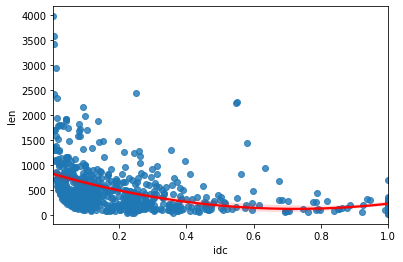

In [82]:
sns.regplot(data=idc, x='idc', y='len', order=2, line_kws={'color':'r'});

Power_divergenceResult(statistic=898.2648792438653, pvalue=2.3389209114849186e-197)

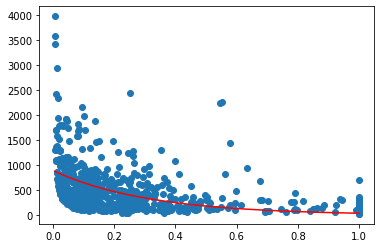

In [86]:


idc = idc.sort_values('idc')
def func(t,a,b):
    return a*np.exp(b*t)

popt, pcov = scipy.optimize.curve_fit(func,  idc.idc,  idc.len)
# popt, pcov  = scipy.optimize.curve_fit(func,  idc.idc,  idc.len)


plt.scatter(idc.idc, idc.len)
plt.plot(idc.idc, func(idc.idc, *popt), 'r')
scipy.stats.chisquare(popt)
# func(idc.idc.values, *popt)

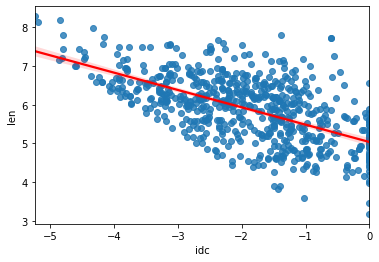

In [91]:
sns.regplot(data=np.log(idc), x='idc', y='len', line_kws={'color':'r'})

In [2]:
pd.read_csv('../baseline/disprot-disorder-pdb-atleast.naive-pdb-atleast-reverse.all.dataset.default.cmat.csv', index_col=[0]).apply(lambda s: s/sum(s)*100, axis=1)

,fn,fp,tn,tp
pdb-atleast-reverse,6.281018,0.0,69.191125,24.527857


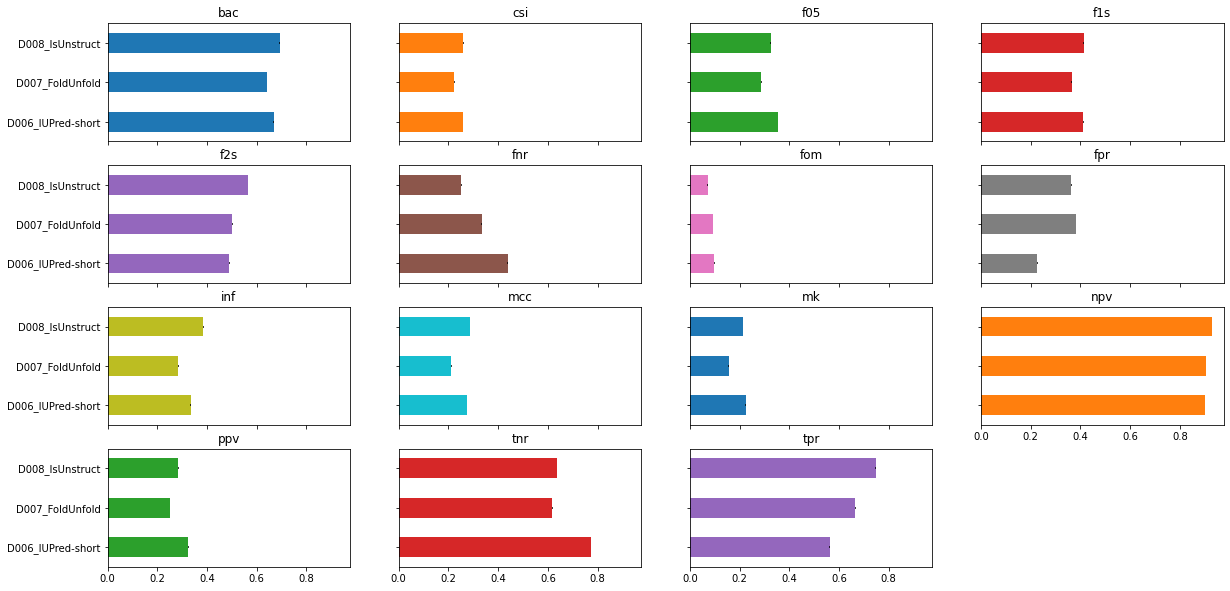

In [21]:
bts = pd.read_csv('../../vectorized_cls_metrics/results/new-disprot-all_simple.analysis.all.bootstrap.default.metrics.csv', index_col=[0,1]).drop('thr', axis=1)
axs = bts.groupby(level=0).mean().plot.barh(subplots=True, layout=(4, 4), figsize=(20, 10), sharey='row', legend=False, xerr=bts.groupby(level=0).std())

In [12]:
r = np.linspace(0, 1, 1000)
fs = scipy.stats.hmean(np.array(np.meshgrid(r, r)).T.reshape(-1, 2), axis=1).reshape(1000, 1000)

<a list of 9 text.Text objects>

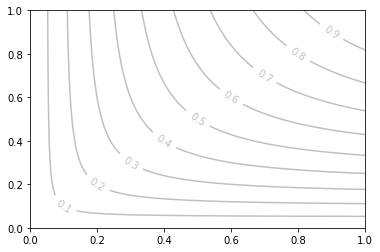

In [46]:
cs = plt.contour(r, r, fs, levels=np.linspace(0.1,1,10), colors='silver')
plt.gca().clabel(cs, inline=True, fmt='%.1f', fontsize=10, manual=[(l,l) for l in cs.levels[:-1]])

In [66]:
r = np.linspace(0, 1, 1000)
fs = np.array(np.meshgrid(r,r)).T.reshape(-1, 2).mean(axis=1).reshape(1000, 1000)

<a list of 9 text.Text objects>

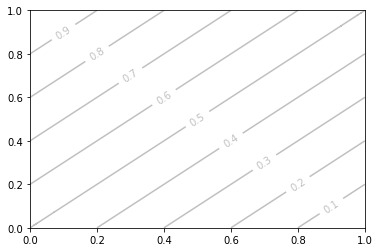

In [68]:
cs = plt.contour(r[::-1],r, fs, levels=np.linspace(0.1, 1, 10), colors='silver')
plt.gca().clabel(cs, inline=True, fmt='%.1f', fontsize=10, manual=[(l,1-l) for l in cs.levels[:-1]])

In [44]:
cputimes = pd.read_csv('../data/dataset_stats/cpu_time.csv', index_col=0, header=[0,1])
np.log(cputimes.mean().unstack())

,hhblits,prediction,psiblast
B001_ANCHOR,NaN,1.814282,NaN
B002_ANCHOR-2,NaN,-2.191844,NaN
B004_MoRFchibi-light,NaN,1.282056,NaN
B005_MoRFchibi-web,NaN,4.680684,NaN
B007_DisoRDPbind,NaN,0.143325,NaN
B008_DisoRDPbind-RNA,NaN,0.143325,NaN
B009_DisoRDPbind-DNA,NaN,0.143325,NaN
B010_DisoRDPbind-protein,NaN,0.143325,NaN
B011_fMoRFpred,NaN,-0.088917,NaN
B012_OPAL,NaN,4.678402,6.598844


In [82]:
set(pd.read_csv('../baseline/disprot-disorder.naive-gene3d-reverse.all.target.f1s.metrics.csv', index_col=[0,1]).index.get_level_values(1)) - \
set(pd.read_csv('../results/disprot-disorder.analysis.all.target.f1s.metrics.csv', index_col=[0,1]).index.get_level_values(1))

{'DP00084', 'DP00182', 'DP00206', 'DP00334', 'DP00359', 'DP00518'}

In [12]:
e = set(pd.read_csv('../results/disprot-binding-all.analysis.all.target.f1s.metrics.csv', index_col=[0,1]).index.get_level_values(1)) - \
set(pd.read_csv('../results/disprot-binding.analysis.all.target.f1s.metrics.csv', index_col=[0,1]).index.get_level_values(1))

pd.read_csv('../results/disprot-binding-all.analysis.all.target.f1s.metrics.csv', index_col=[0,1]).loc['B001_ANCHOR'].reindex(e).f1s.count()

0

In [1]:
dst = pd.read_csv('../data/dataset_stats/references-stats.target.csv', index_col=[0,1], header=[0,1])
dst = dst.loc['disprot-disorder']
ax = dst.data.groupby('species').count().taxon.sort_values().plot.barh(figsize=(4, 18), logx=True)
plt.tick_params(axis='x', which='both', labeltop='on', labelbottom='on', top='on')
ax.vlines([1, 10, 100], 0, len(dst), linestyle='--', linewidth=1, color='silver', zorder=0)

NameError: name 'pd' is not defined

In [3]:
disprot_annotations = json.load(open('../data/annotations/disprot-2018-11.json'))

In [4]:
bregs = []
for entry in disprot_annotations['data']:
    bregs.extend(list(filter(lambda e: e['term_namespace'] == 'Interaction partner', entry['regions'])))

Text(0, 0.5, '')

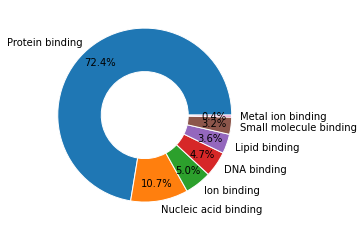

In [5]:
s = pd.Series([r['term_name'] for r in bregs]).value_counts()
ax = s[s > 2].plot.pie( autopct='%1.1f%%', wedgeprops=dict(width=0.5, edgecolor='w'), pctdistance=0.8)
ax.set_ylabel(None)

In [6]:
caid_curators = set([r['curator_name'] for r in bregs])

In [7]:
intact_interactors = pd.read_csv('../data/intact.zip', sep='\t', dtype=str)

In [22]:
search_terms = ['direct binding region', 'binding-associated region', 'sufficient binding region', 'necessary binding region']
intact_interactions = set.union(
    *pd.concat(
        [
        intact_interactors['Feature(s) interactor A'].str.extract(r'({}):(\d+-\d+)'.format('|'.join(search_terms))).dropna()[1].str.split('-', expand=True).rename({0: 'start', 1:'end'}, axis=1),
        intact_interactors['Alt. ID(s) interactor A'].str.extract(r'([OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2})')[0].dropna().rename('uid')
        ], axis=1
    ).dropna().apply(lambda row: set(row['uid'] + str(res) for res in range(int(row['start'])-1, int(row['end']))), axis=1).values
) & set.union(
    *pd.concat(
        [
        intact_interactors['Feature(s) interactor B'].str.extract(r'({}):(\d+-\d+)'.format('|'.join(search_terms))).dropna()[1].str.split('-', expand=True).rename({0: 'start', 1:'end'}, axis=1),
        intact_interactors['Alt. ID(s) interactor B'].str.extract(r'([OPQ][0-9][A-Z0-9]{3}[0-9]|[A-NR-Z][0-9]([A-Z][A-Z0-9]{2}[0-9]){1,2})')[0].dropna().rename('uid')
        ], axis=1
    ).dropna().apply(lambda row: set(row['uid'] + str(res) for res in range(int(row['start'])-1, int(row['end']))), axis=1).values
)

In [30]:
caid_disprot_ids_bind = set(pd.read_csv('../results/disprot-binding.analysis.all.target.default.metrics.csv', index_col=[0, 1]).index.get_level_values(1))
disprot_interactors = set(entry['acc'] for entry in disprot_annotations['data'] if entry['disprot_id'] in caid_disprot_ids_bind)

In [31]:
root = ET.fromstring(gzip.open('../data/IDEAL.xml.gz').read())
ideal_entries = set(entry.find('General').find('uniprot').text for entry in root.findall('IDEAL_entry'))

In [32]:
mfib_entries = set([line.strip().split('=')[1] for line in open('../data/MFIB_complete.txt') if line.startswith('[Chain A UniProt accession]') or line.startswith('[Chain B UniProt accession]')])
dibs_entries = set([line.strip().split('=')[1] for line in open('../data/DIBS_complete.txt') if line.startswith('[Chain A UniProt accession]') or line.startswith('[Chain B UniProt accession]')])
caid_disprot_ids_dis = set(pd.read_csv('../results/disprot-disorder.analysis.all.target.default.metrics.csv', index_col=[0, 1]).index.get_level_values(1))
disprot_entries = set(entry['acc'] for entry in disprot_annotations['data'] if entry['disprot_id'] in caid_disprot_ids_dis)

<AxesSubplot:>

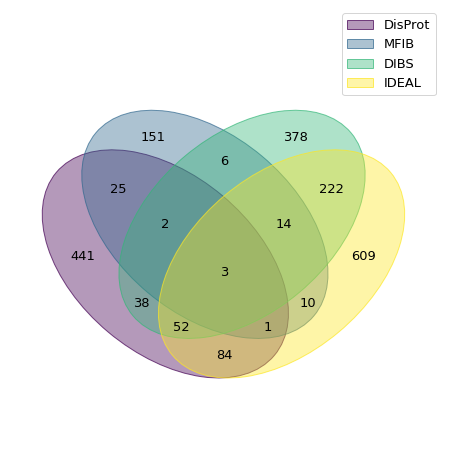

In [33]:
venn({'DisProt': disprot_entries, 'MFIB': mfib_entries, 'DIBS': dibs_entries, 'IDEAL': ideal_entries})

In [34]:
def get_interactions(exclude=None):
    interactions = {}
    with open('../data/curated.mjson') as curated:
        for line in curated:
            entry = json.loads(line.strip())
            for key in entry:
                if 'lip' in key or 'binding' in key:
                    if 'disprot' not in key and (exclude is None or key.split('-')[-1] not in exclude):
                        for reg in entry[key]['regions']:
                            interactions.setdefault(key.split('-')[-1].upper(), set()).update(set(map(lambda res: entry['acc'] + str(res), range(reg[0], reg[1] + 1))))
    return interactions

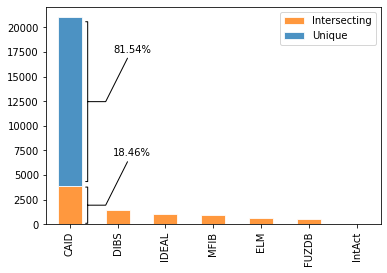

In [110]:
interactions = get_interactions()
interactions['IntAct'] = intact_interactions
disprot_binding_residues = pd.read_csv('../results/disprot-binding.analysis.all.dataset._.predictions.csv', index_col=[0,1], header=[0,1])['ref']['states']
disprotid_to_uniprot = {entry['disprot_id']: entry['acc'] for entry in disprot_annotations['data']}
disprot_binding_residues = disprot_binding_residues[disprot_binding_residues == 1].to_frame()
disprot_binding_residues['uid'] = [disprotid_to_uniprot[did] for did in disprot_binding_residues.index.get_level_values(0)]
disprot_binding_residues = disprot_binding_residues.reset_index()
disprot_binding_residues = set(disprot_binding_residues['uid'] + disprot_binding_residues['level_1'].astype(str))

intersection_with_disprot = pd.DataFrame(columns=['Intersecting', 'Unique'], dtype=int)

alldbs = set()
for db in interactions:
    alldbs.update(interactions[db])
    intersection_with_disprot.loc[db, 'Intersecting'] = len(interactions[db] & disprot_binding_residues)

intersection_with_disprot.loc['CAID', 'Intersecting'] = len(alldbs & disprot_binding_residues)
intersection_with_disprot.loc['CAID', 'Unique'] = len(disprot_binding_residues) - intersection_with_disprot.loc['CAID', 'Intersecting']

ax = intersection_with_disprot.sort_values(by='Intersecting', ascending=False).plot.bar(stacked=True, color=['tab:orange', 'tab:blue'], edgecolor='w', alpha=.8)

for i, p in enumerate(ax.patches):
    if i == 0 or i == (len(ax.patches)/2):
        x = p.get_x() + (p.get_width() / 2)
        y = p.get_y() + (p.get_height() / 2)
        
        height_fraction = p.get_height() / intersection_with_disprot.loc['CAID'].sum()
        
        ax.annotate('{:.2f}%'.format(height_fraction*100), 
                    xy=(x + p.get_width()/1.5, y), 
                    xytext=(1.3, y+5000), 
                    horizontalalignment='center',
                    arrowprops = {
                        'arrowstyle': ArrowStyle('-[', widthB=height_fraction*9.8, lengthB=0.2, angleB=None),
                        'connectionstyle': "arc,angleA=-90,angleB=0,armA=0,armB=20,rad=0"
                    }
                   )

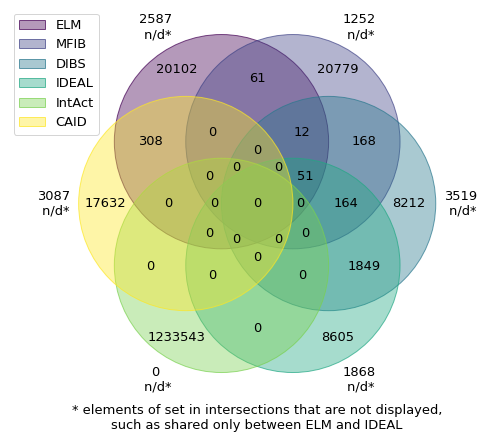

In [29]:
interactions['CAID'] = disprot_binding_residues
ax = pseudovenn(interactions, legend_loc='upper left')